In [29]:
%load_ext autoreload
%aimport processing
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
%autoreload 1

import pandas as pd
import numpy as np

import datetime
from datetime import timezone
import pytz
import matplotlib.pyplot as plt
from pycoingecko import CoinGeckoAPI

from CGProcessor import CGProcessor
import statsmodels.tsa.stattools as ts
import hurst

In [31]:
cg = CoinGeckoAPI()

In [32]:
###############
## CONSTANTS ##
###############

NAT_TZ = 'America/Los_Angeles'
NAT_TZOBJ = pytz.timezone(NAT_TZ)

TRG_TZOBJ = timezone.utc

#PORT_IDS = [['bitcoin',5], ['bitcoin-cash',1], ['ethereum',2.22], ['litecoin',-200]]
PORT_IDS = ['bitcoin','ethereum','litecoin','bitcoin-cash']

NAT_CURR = 'usd'

LOOKBACKS = [7, 14, 30]
ROLL_WIND = LOOKBACKS[1]

In [33]:
##################
## LOCAL DRIVER ##
##################

start_date, end_date = (2018,9,1), (2020,9,1)

processor = CGProcessor()

# Create portfolio dataframe
port_val = processor.create_portfolio(PORT_IDS, start_date, end_date)
data = processor.data

processor.normalize([], port=True)

In [34]:
display(processor.portfolio)

1535760000000    1.000000
1535846400000    1.034940
1535932800000    1.050535
1536019200000    1.041414
1536105600000    1.053503
                   ...   
1598572800000    1.516318
1598659200000    1.546338
1598745600000    1.542080
1598832000000    1.575485
1598918400000    1.572076
Length: 732, dtype: float64

In [56]:
########################
# Stationarity Testing #
########################

# tests: Augmented Dickey-Fuller, Variance Ratio, KPSS, 

# Unit Root tests
def aug_df(series):
     t_stat, pval, _,_, crit_vals,_ = ts.adfuller(series)
     print(f'ADF Statistic: {t_stat:.2f}')
     for key, value in crit_vals.items():
          print('Critial Values:')
          print(f'   {key}, {value:.2f}')

     print(f'\np-value: {pval:.2f}')
     print("Non-Stationary") if pval > 0.05 else print("Stationary")
     if pval < 0.05:
          return True
     return False

aug_df(processor.portfolio)

ADF Statistic: -1.11
Critial Values:
   1%, -3.44
Critial Values:
   5%, -2.87
Critial Values:
   10%, -2.57

p-value: 0.71
Non-Stationary


False

In [59]:
# The KPSS test has null hypothesis of stationarity
def kpss(series):
     t_stat, p_value, _, critical_values = ts.kpss(series,nlags='auto')

     print(f'T-Statistic: {t_stat:.2f}')
     for key, value in critical_values.items():
          print('Critial Values:')
          print(f'   {key}, {value:.2f}')

     print(f'\np-value: {p_value:.2f}')
     print("Stationary") if p_value > 0.05 else print("Non-Stationary")
     return False if p_value > 0.05 else True

kpss(processor.portfolio)


T-Statistic: 1.83
Critial Values:
   10%, 0.35
Critial Values:
   5%, 0.46
Critial Values:
   2.5%, 0.57
Critial Values:
   1%, 0.74

p-value: 0.01
Non-Stationary


/home/dave/anaconda3/envs/finml/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


True

This is an example of a non-stationary series. My goal is to see which tests can figure that out.

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


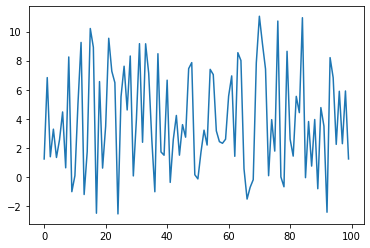

In [80]:
t = np.arange(0,100)
print(t)

y_1 = np.array([4 + np.sin(x) + np.random.uniform(-2*np.pi,2*np.pi) for x in t])

plt.plot(t,y_1);

In [81]:
aug_df(y_1)

ADF Statistic: -6.51
Critial Values:
   1%, -3.50
Critial Values:
   5%, -2.89
Critial Values:
   10%, -2.58

p-value: 0.00
Stationary


True

In [82]:
kpss(y_1)

T-Statistic: 0.07
Critial Values:
   10%, 0.35
Critial Values:
   5%, 0.46
Critial Values:
   2.5%, 0.57
Critial Values:
   1%, 0.74

p-value: 0.10
Stationary


/home/dave/anaconda3/envs/finml/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


False

In [86]:
print(hurst.compute_Hc(y_1))

(0.11060673294663054, 1.5624972832276989, [[10, 17, 31, 56, 100], [1.9869385818368144, 2.1578203722704536, 2.337195609266502, 2.3955062093184503, 2.6003775313352255]])


In [78]:
def variance_ratio(series, lag = 2):
    """
    Returns the variance ratio test result
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(series)
    
    # Apply the formula to calculate the test
    n = len(series)
    mu  = sum(series[1:n]-series[:n-1])/n;
    m=(n-lag+1)*(1-lag/n);
    b=sum(np.square(series[1:n]-series[:n-1]-mu))/(n-1)
    t=sum(np.square(series[lag:n]-series[:n-lag]-lag*mu))/m
    return t/(lag*b);

In [79]:
variance_ratio(y_1)    

0.47064041637734977

In [ ]:
def half_life(ts):  
    """ 
    Calculates the half life of a mean reversion
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)
    
    # delta = p(t) - p(t-1)
    delta_ts = np.diff(ts)
    
    # calculate the vector of lagged values. lag = 1
    lag_ts = np.vstack([ts[1:], np.ones(len(ts[1:]))]).T
   
    # calculate the slope of the deltas vs the lagged values 
    beta = np.linalg.lstsq(lag_ts, delta_ts)
    
    # compute and return half life
    return (np.log(2) / beta[0])[0]